# Eyeblink correction


So let's say you have some data from the stream and have saved it into a (temporary) file, such as can be found in:

**/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif**

In order to do an eyeblink correction, you'd wish to load that data in, perhaps inspect it, then run an ICA, and then use the ICA weights for spatially filtering the real-time data stream coming in later.

First we load in the example data

In [25]:
filename = '/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif'

In [26]:
import mne

In [27]:
raw=mne.io.read_raw_fif(filename)

Opening raw data file /home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif...
    Range : 0 ... 179974 =      0.000 ...   179.974 secs
Ready.


<ipython-input-27-ffab7c54e237>:1: RuntimeWarning: This filename (/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw=mne.io.read_raw_fif(filename)


ok we violate MNE's naming convention but we still load it in

In [28]:
%matplotlib qt

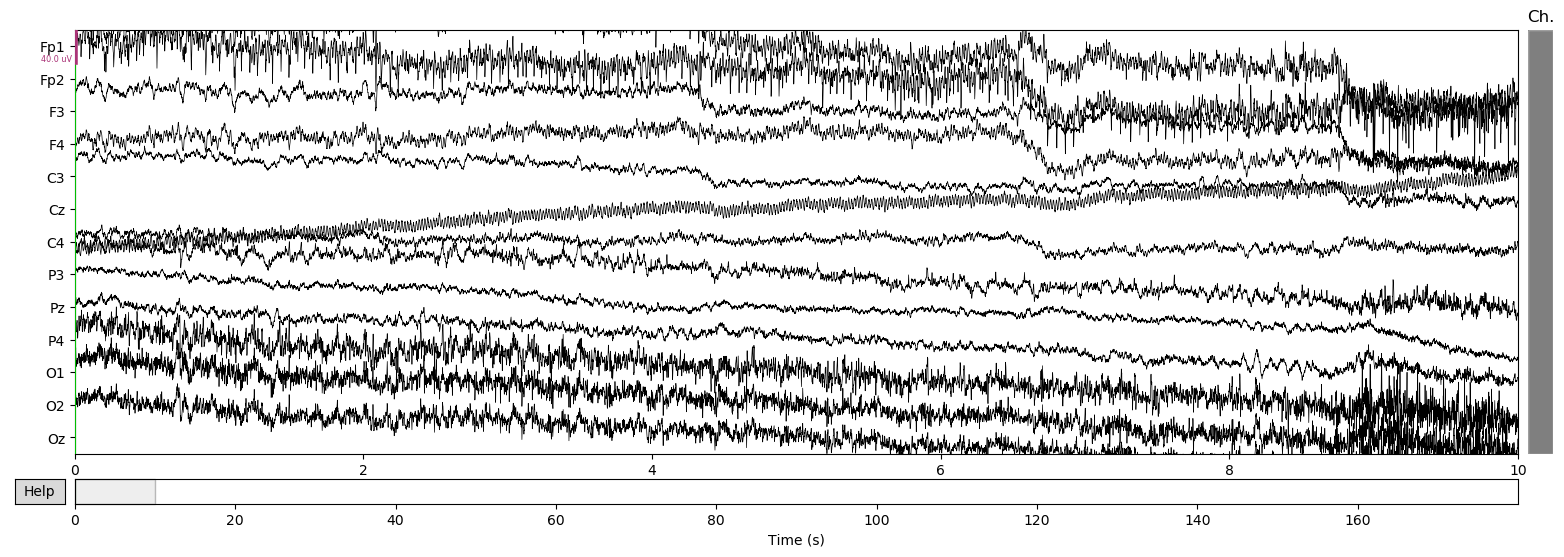

In [29]:
raw.plot()

Check the data between 96 and 111 - ideal for detecting eyeblinks, since here we instructed the participant to actually blink a couple of times

In theory it is ideal, except for when the participant misunderstands... (we had one case of this happening)

In [30]:
# let's select the part between 100 and 116:
raw.crop(96,111)

<Raw  |  example.fif, n_channels x n_times : 13 x 15001 (15.0 sec), ~41 kB, data not loaded>

Now we can do ICA, as per shown in the MNE Turorials web page:
[https://mne.tools/stable/auto_tutorials/index.html](https://mne.tools/stable/auto_tutorials/index.html)

subsection 'Repairing artifacts with ICA'

In [31]:
# and let's do the ICA

from mne.preprocessing import ICA

In [32]:
ica=ICA()

ica.fit(raw)

Fitting ICA to data using 13 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 13
Fitting ICA took 0.9s.


<ICA  |  raw data decomposition, fit (fastica): 15001 samples, 13 components, channels used: "eeg">

now we compare sensor space

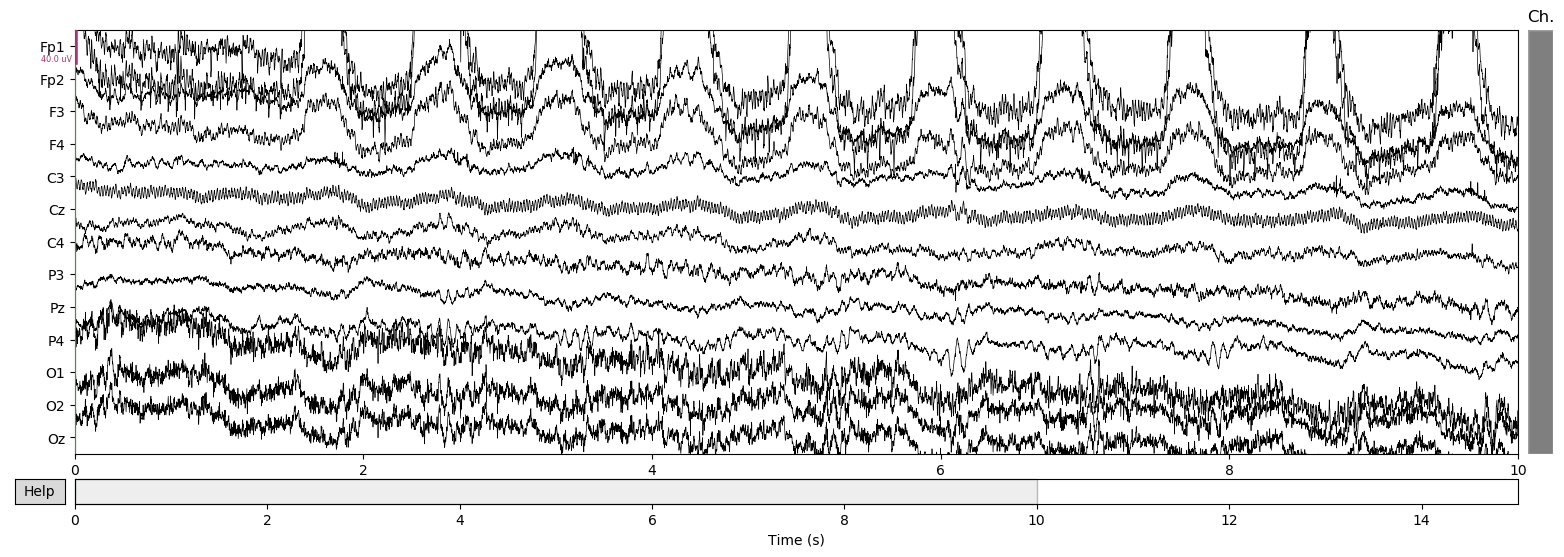

In [35]:
raw.plot()

with component space

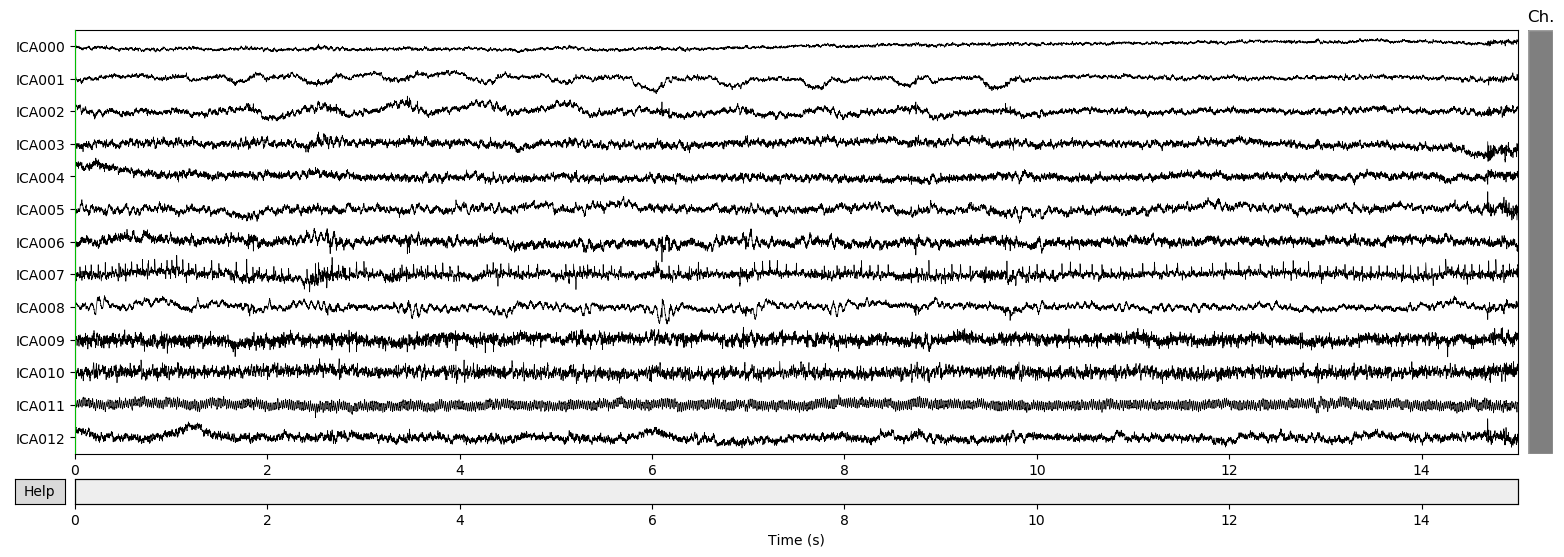

In [34]:
ica.plot_sources(raw)

So probably component number 1 and maybe 2 (not 2 and 3 - it starts with 0). It depends on the current ICA run if it's always component 2, since there is some randomization going on when you calculate an ICA. So basically you'd always have to eyeball it. Or write a nice way to 'learn' what a typical eyeblink component looks like within the current EEG system that you have.

We can also plot components as a topographical image

In [36]:
ica.plot_components()

[<Figure size 750x550 with 15 Axes>]

And we can tell ica to exclude them:

In [38]:
ica.exclude = [1, 2]

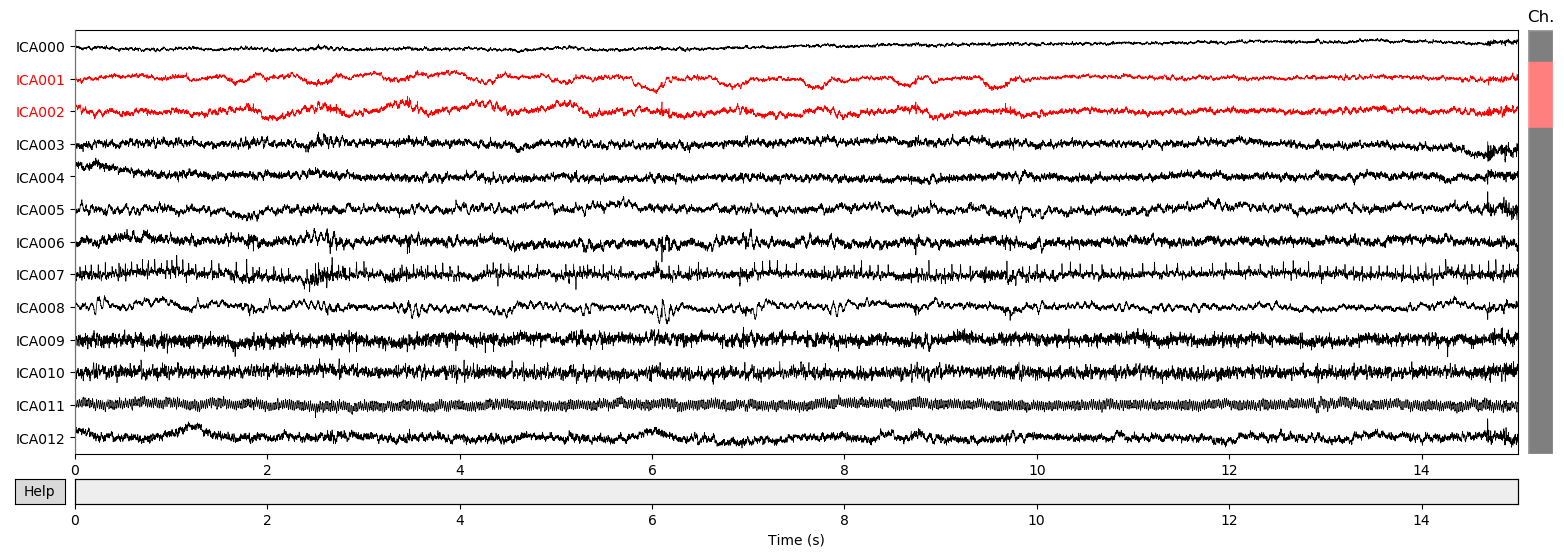

In [42]:
ica.plot_sources(raw)

In [56]:
# apply it -- and compare raw vs raw_with_ica_applied

raw_after_ica = raw.copy()

In [59]:
raw_after_ica.load_data()  # we need to load it into memory
                           # as ica doens't work on a memory-mapped file

<Raw  |  example.fif, n_channels x n_times : 13 x 15001 (15.0 sec), ~1.5 MB, data loaded>

In [60]:
ica.apply(raw_after_ica)

Transforming to ICA space (13 components)
Zeroing out 2 ICA components


<Raw  |  example.fif, n_channels x n_times : 13 x 15001 (15.0 sec), ~1.5 MB, data loaded>

Compare!

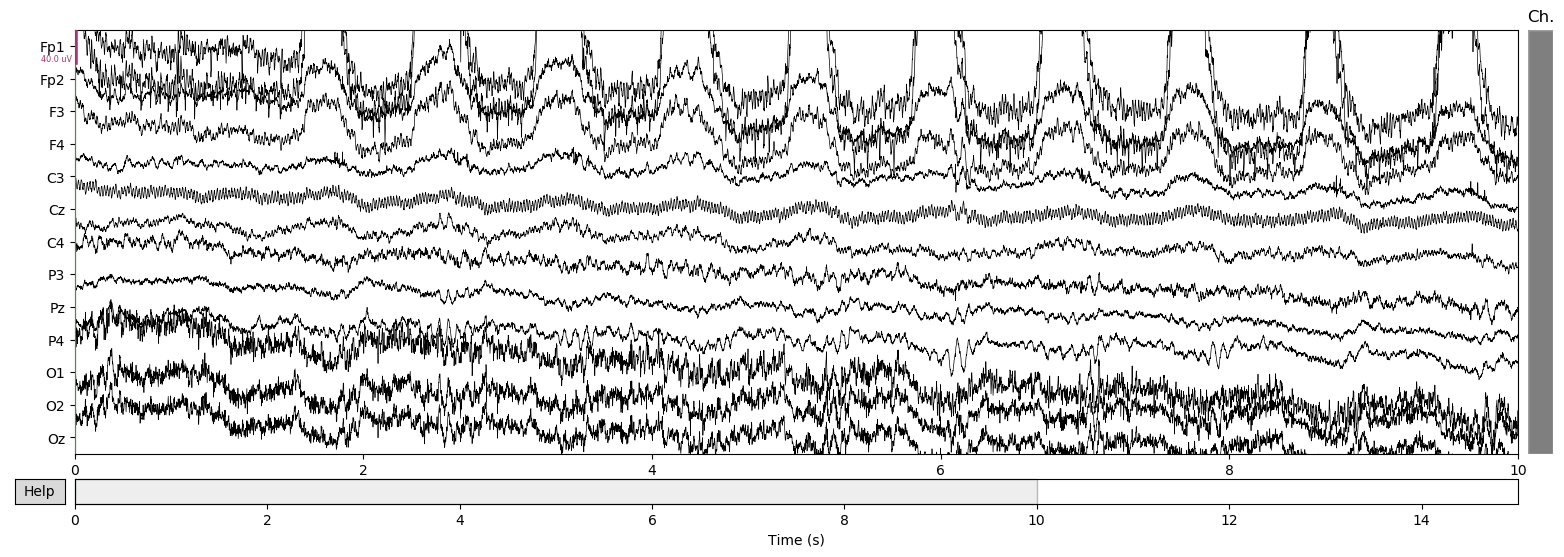

In [62]:
raw.plot()

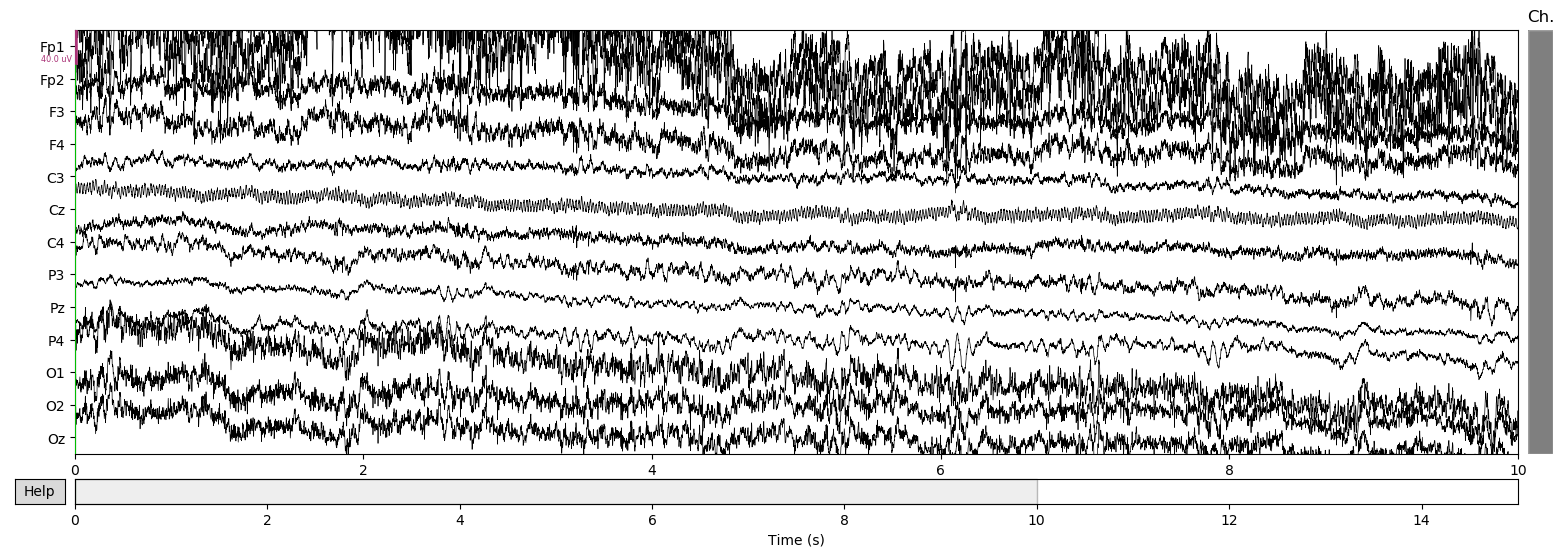

In [61]:
raw_after_ica.plot()

In [63]:
# so that works - and everything we need is in the ica object.
ica.pca_mean_

<ICA  |  raw data decomposition, fit (fastica): 15001 samples, 13 components, channels used: "eeg", 2 sources marked for exclusion>

### test it myself

using documentations from here:
[https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA)

In [72]:
mydata = raw.get_data()

In [93]:
data_mean = ica.pca_mean_

In [97]:
data_mean

array([-2.25428711, -4.31135572, -1.69623535, -2.4899757 , -0.52476659,
       -1.19464485, -0.88866762, -2.60342163, -1.60915303, -0.75772244,
       -2.19479003, -0.94830012, -1.03387225])

In [95]:
import numpy as np

In [96]:
mydata.mean(axis=1)

array([-0.00951206, -0.01819195, -0.00715734, -0.01050656, -0.00221428,
       -0.00504086, -0.00374977, -0.01098525, -0.00678989, -0.00319724,
       -0.00926101, -0.00400139, -0.00436247])

In [98]:
ica.pre_whitener_

array([[0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954],
       [0.00421954]])